## Introduction

In this notebook, we are going to explore and analyze sales data from Russian software firm - 1C Company. Full description of this dataset can be seen at https://www.kaggle.com/c/competitive-data-science-predict-future-sales. In this dataset, number of sales are recorded daily for each item and each shop from January 2013 to October 2015. Hence, it forms a time series data with one day frequency. The aim of this project is to gain information (such as trend and pattern) using time series analysis and perform simple forecasting with statistical model.

Actually, the original task of this dataset (as stated in Kaggle) is to forecast total sales for each item-shop combination in the next month. This task can't be handled by traditional statistical time series analysis so we have to use advanced machine learning method for time series such as XGBoost and Long Short-Term Memory (LSTM) neural network. Instead, we will try to forecast the total sales summed over each item-shop combination. With this task, we can employ statistical time series analysis with ease. 

## Importing Dataset

In [1]:
import numpy as np
import pandas as pd
from pandas import Series, DataFrame
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

C:\Users\ASUS\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Download dataset from shared google drive file.

In [2]:
!pip install googledrivedownloader
from google_drive_downloader import GoogleDriveDownloader as gdd
import os
gdd.download_file_from_google_drive(file_id='1krsbWaR8MgN1WbQlVLCCZaxYiKMEHBGD',
                                    dest_path='./time_series.zip',
                                    unzip=True)

You should consider upgrading via the 'python -m pip install --upgrade pip' command.


Unzipping...Done.


In [2]:
df = pd.read_csv('sales_train.csv')
df.date = pd.to_datetime(df.date, format='%d.%m.%Y')
df

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,2013-01-02,0,59,22154,999.00,1.0
1,2013-01-03,0,25,2552,899.00,1.0
2,2013-01-05,0,25,2552,899.00,-1.0
3,2013-01-06,0,25,2554,1709.05,1.0
4,2013-01-15,0,25,2555,1099.00,1.0
...,...,...,...,...,...,...
2935844,2015-10-10,33,25,7409,299.00,1.0
2935845,2015-10-09,33,25,7460,299.00,1.0
2935846,2015-10-14,33,25,7459,349.00,1.0
2935847,2015-10-22,33,25,7440,299.00,1.0


## Brief Exploratory Data Analysis (EDA)

In [3]:
df.describe()

,date_block_num,shop_id,item_id,item_price,item_cnt_day
count,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06
mean,1.456991e+01,3.300173e+01,1.019723e+04,8.908532e+02,1.242641e+00
std,9.422988e+00,1.622697e+01,6.324297e+03,1.729800e+03,2.618834e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,-2.200000e+01
25%,7.000000e+00,2.200000e+01,4.476000e+03,2.490000e+02,1.000000e+00
50%,1.400000e+01,3.100000e+01,9.343000e+03,3.990000e+02,1.000000e+00
75%,2.300000e+01,4.700000e+01,1.568400e+04,9.990000e+02,1.000000e+00
max,3.300000e+01,5.900000e+01,2.216900e+04,3.079800e+05,2.169000e+03


As we can see, minimum value of item_price and item_cnt_day is negative. This is quite confusing as price and number of sales cannot be a negative number. We can check how many records that have these negative values.

In [4]:
print('Number of records with negative item_price: %d' %(len(df[df['item_price'] < 0])))
print('Number of records with negative item_cnt_day: %d' %(len(df[df['item_cnt_day'] < 0])))

Number of records with negative item_price: 1
Number of records with negative item_cnt_day: 7356


### Negative item_price value

Only one record has negative item_price on it (item_id = 2973). 

In [5]:
df[df['item_price']<0]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
484683,2013-05-15,4,32,2973,-1.0,1.0


It is mostly like that an error or typo occured when assigning this value. Also, we can check every prices for item 2973 to confirm this error.

In [6]:
df[df['item_id'] == 2973].item_price.unique()

array([ 2.49900000e+03,  2.42757143e+03,  2.49850000e+03,  2.49883333e+03,
        2.49875000e+03,  2.49891667e+03,  1.90100000e+03,  1.99900000e+03,
        2.49887500e+03,  2.49890000e+03,  2.24900000e+03,  2.37395000e+03,
        2.49870000e+03,  2.49840000e+03,  1.99840000e+03,  1.24950000e+03,
        1.24900000e+03,  1.24910000e+03, -1.00000000e+00,  1.24890000e+03,
        1.04900000e+03,  2.24880000e+03,  1.56203000e+03,  1.48761000e+03,
        1.27527000e+03,  1.27501000e+03,  1.38840000e+03,  1.32929000e+03,
        1.52391000e+03,  1.83785000e+03,  1.45300000e+03,  1.45412000e+03,
        1.29758000e+03,  1.25000000e+03,  1.24870000e+03,  1.83237000e+03])

Best solution to handle this anomaly record is to drop it (select only records with non-negative item price).

In [7]:
df = df[df['item_price'] > 0]

### Negative item_cnt_day value

In [8]:
df[df['item_cnt_day']<0]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
2,2013-01-05,0,25,2552,899.0,-1.0
148,2013-01-23,0,25,2321,999.0,-1.0
175,2013-01-07,0,25,2199,1449.0,-1.0
807,2013-01-02,0,25,2330,599.0,-1.0
1041,2013-01-13,0,25,5034,1989.0,-1.0
...,...,...,...,...,...,...
2934243,2015-10-26,33,25,3917,449.0,-1.0
2934462,2015-10-18,33,25,4896,6398.0,-1.0
2935263,2015-10-05,33,25,10039,249.0,-1.0
2935643,2015-10-16,33,25,7893,2990.0,-1.0


There are few number of records which has negative number of sales on it. Speaking of percentage, these 'abnormal' records have very small proportion to the entire records.

In [9]:
print('Proportion of records with negative item_cnt_day: %f%%' %(100*len(df[df['item_cnt_day']<0])/len(df)))

Proportion of records with negative item_cnt_day: 0.250558%


Nevertheless, we try not to drop these records because it may be valuable. Alternatively, we can interpret these negative sales as returned items (refund). With this interpretation, we should replace all the negative values with zeroes.

In [10]:
df.loc[df['item_cnt_day']<0,'item_cnt_day'] = 0

C:\Users\ASUS\Anaconda3\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


### Distribution of value

Now, let's look out the distribution plot of item_price and item_cnt_day using boxplot.

In [11]:
df.describe()

,date_block_num,shop_id,item_id,item_price,item_cnt_day
count,2.935848e+06,2.935848e+06,2.935848e+06,2.935848e+06,2.935848e+06
mean,1.456992e+01,3.300173e+01,1.019723e+04,8.908535e+02,1.245210e+00
std,9.422987e+00,1.622698e+01,6.324297e+03,1.729800e+03,2.617046e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,7.000000e-02,0.000000e+00
25%,7.000000e+00,2.200000e+01,4.476000e+03,2.490000e+02,1.000000e+00
50%,1.400000e+01,3.100000e+01,9.343000e+03,3.990000e+02,1.000000e+00
75%,2.300000e+01,4.700000e+01,1.568400e+04,9.990000e+02,1.000000e+00
max,3.300000e+01,5.900000e+01,2.216900e+04,3.079800e+05,2.169000e+03


Text(0.5, 0.98, 'Distribution of item price and item sales per day')

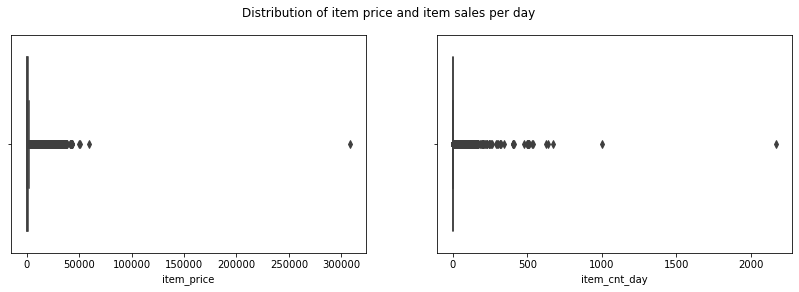

In [12]:
f, (ax1, ax2) = plt.subplots(figsize=(14,4), nrows=1, ncols=2)
sns.boxplot(df['item_price'].dropna(), ax=ax1)
sns.boxplot(df['item_cnt_day'].dropna(), ax=ax2)
f.suptitle('Distribution of item price and item sales per day')

The item_price plot indicates that almost every item has price value with order of magnitude of 10<sup>2</sup>. Surprisingly, a lot of items also have extremely high prices with order of magnitude of 10<sup>3</sup>-10<sup>4</sup>. One item has price at around 300000 which is very extreme compared to the other item prices. Let's take a look at what kind of item is it.

In [13]:
items = pd.read_csv('items.csv')
items[items['item_id']==df[df['item_price']==df['item_price'].max()].item_id.values[0]]  

,item_name,item_id,item_category_id
6066,Radmin 3 - 522 лиц.,6066,75


So the item with the most extreme high price value is Radmin 3. This item is sort of PC Remote Control Software. The price is very high indeed as can be checked in internet.

For item_cnt_day, the plot indicates that almost every item in every shop purchased in single quantity (only one item per day). Nevertheless, a lot of items have been purchased more than one per day. The most extreme case is the transaction with > 2000 items per day. Let's take a look at what kind of item is it.

In [14]:
items = pd.read_csv('items.csv')
items[items['item_id']==df[df['item_cnt_day']==df['item_cnt_day'].max()].item_id.values[0]]  

,item_name,item_id,item_category_id
11373,Доставка до пункта выдачи (Boxberry),11373,9


### Time series of each shop

Now, let's take a peek for the time series. Before doing the actual analysis on the total summed sales (over all shops and items), we are going to examine total sales for each shop. This means that we will perform summation over all item sales in each shop. After that, we plot the number of sales as function of time for each shop. There are 60 shops in total. We will look at 20 first shops for clarity.

In [15]:
per_shop = df.groupby(['shop_id','date'],as_index=False)['item_cnt_day'].sum()
per_shop

,shop_id,date,item_cnt_day
0,0,2013-01-03,203.0
1,0,2013-01-04,352.0
2,0,2013-01-05,292.0
3,0,2013-01-06,209.0
4,0,2013-01-07,132.0
...,...,...,...
47223,59,2015-10-27,34.0
47224,59,2015-10-28,14.0
47225,59,2015-10-29,14.0
47226,59,2015-10-30,30.0


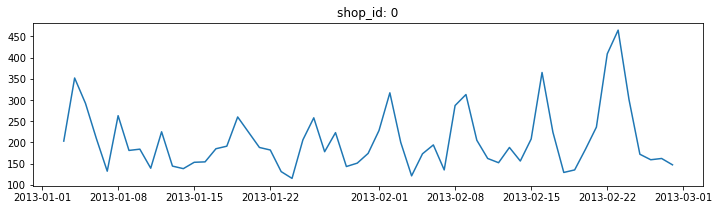

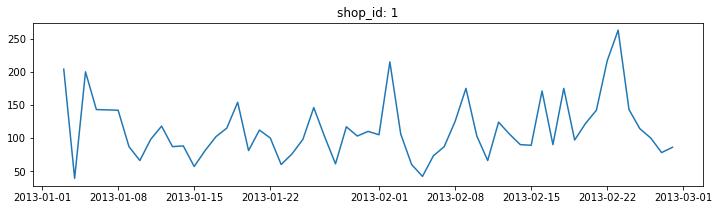

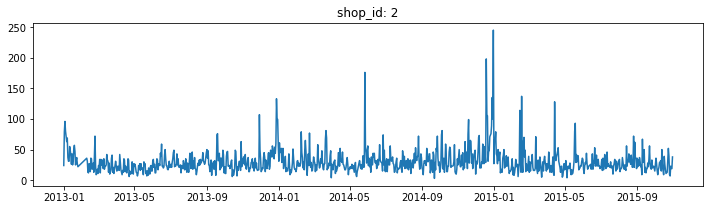

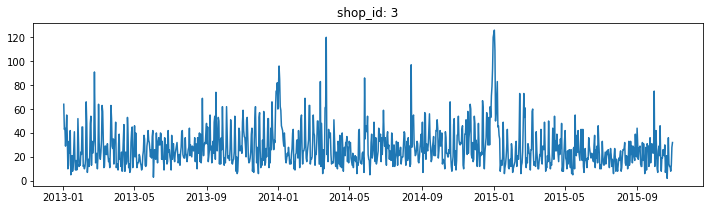

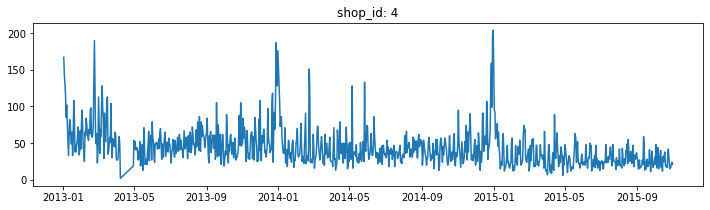

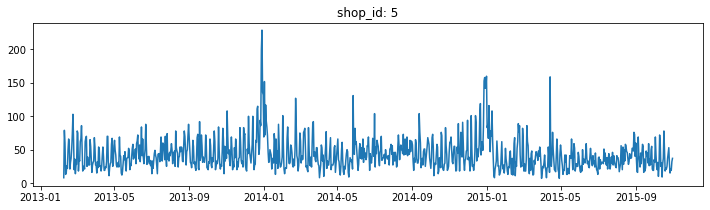

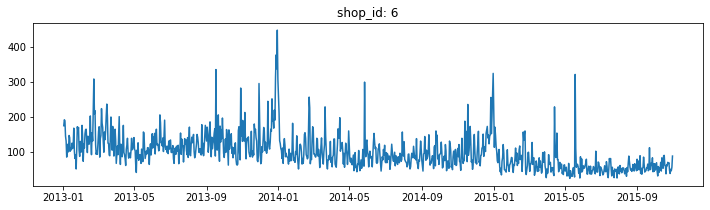

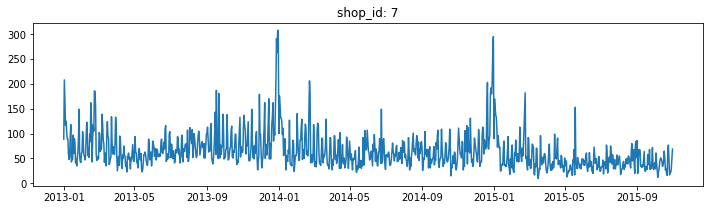

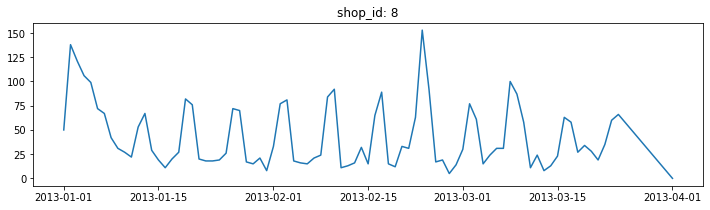

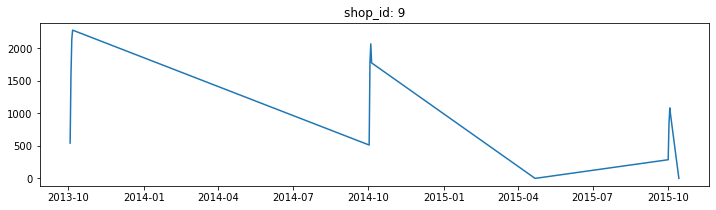

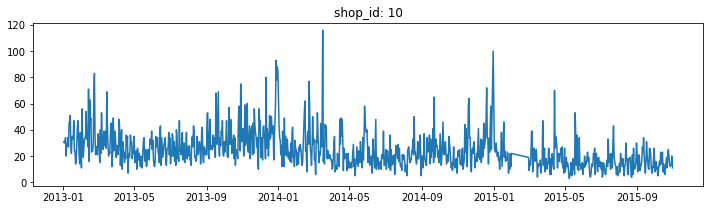

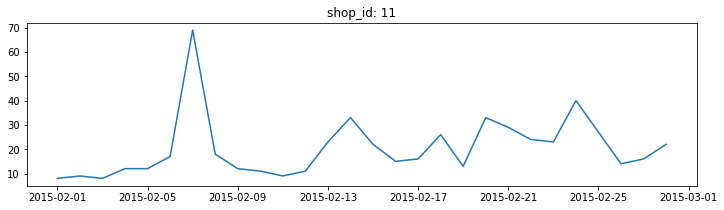

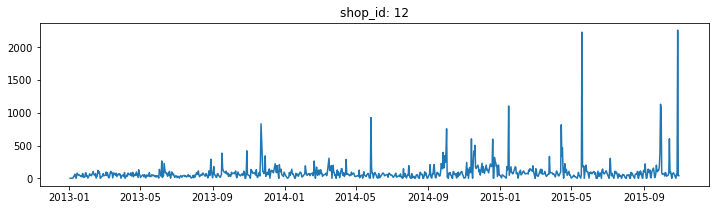

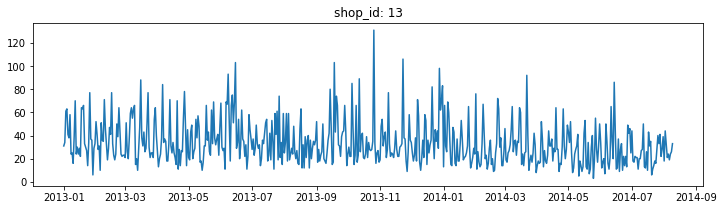

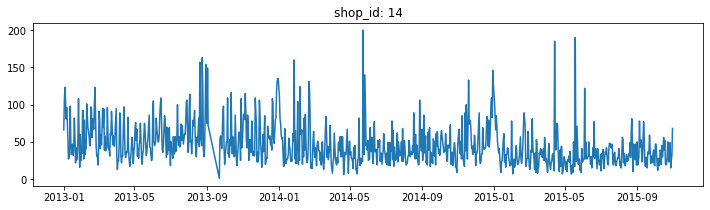

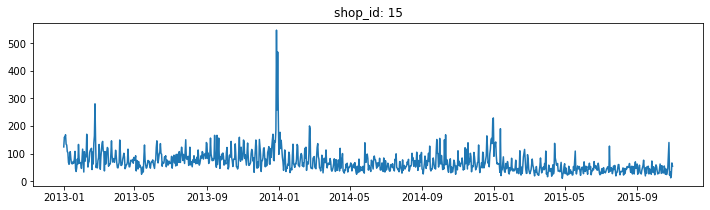

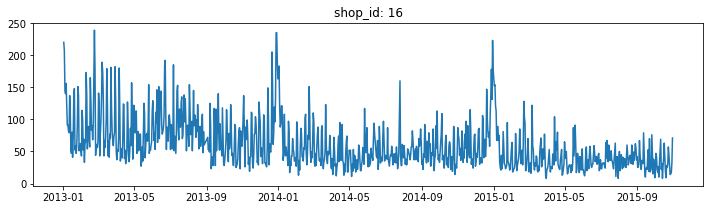

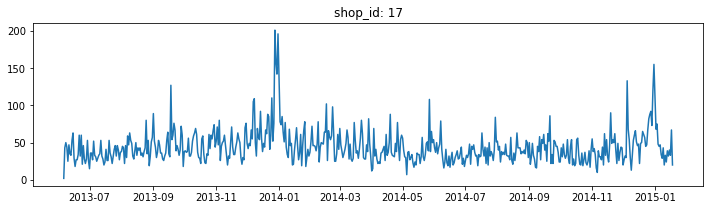

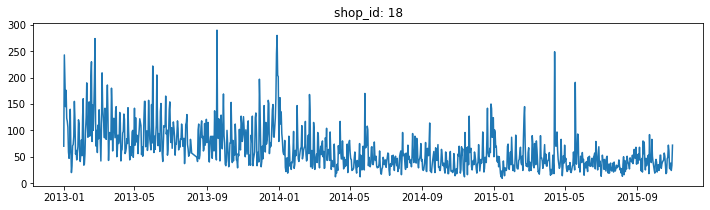

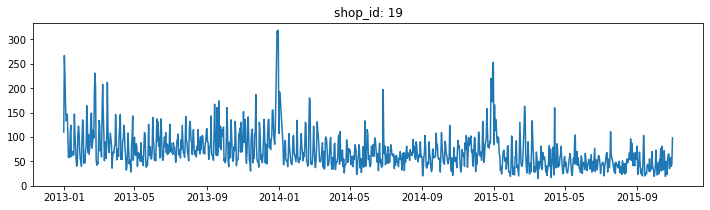

In [16]:
for c in range(0,20):
    fig = plt.figure(figsize=(12,3))
    plt.plot(per_shop[per_shop.shop_id==c].set_index('date')['item_cnt_day'])
    plt.title('shop_id: %d' %(c))

We can see that every shop has its own unique pattern. Some shops only have transactions in 2013 (i.e. shop 0, shop 1, and shop 8). Some shops also only have a few transactions from 2013-2015 (shop 9). Roughly speaking, data distribution in each shop is not equal so analyzing each shop sales will be challengin and difficult.

## Time Series Analysis

### Daily pattern

Now, let's proceed to our main objective: perform time series analysis on the total sales summed over all shops and items combination each day. 

Text(0.5, 1.0, 'Total sales per day from January 2013 - October 2015')

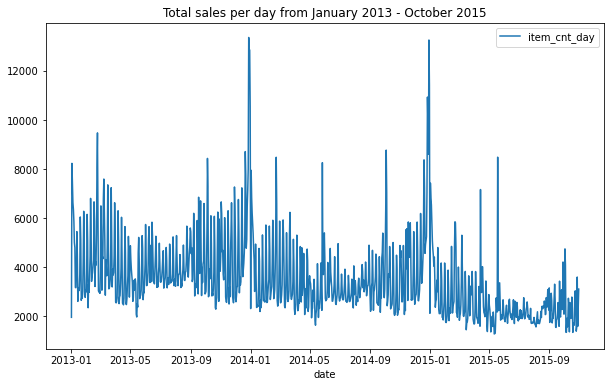

In [17]:
daily = df.groupby(['date'],as_index=False)['item_cnt_day'].sum()
daily = daily.set_index('date')
plt.figure(figsize=(10,6))
sns.lineplot(data=daily)
plt.title('Total sales per day from January 2013 - October 2015')

The plot is not quite clear. It seems that each peak appears in weekly period. For clarity, let's look the daily sales in the first month (January 2013).

Text(0.5, 1.0, 'Total sales per day in January 2013')

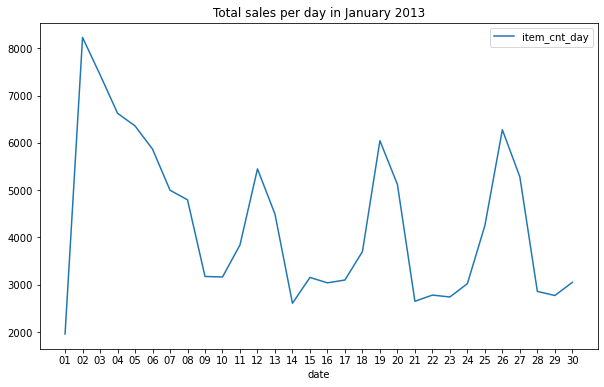

In [18]:
plt.figure(figsize=(10,6))
sns.lineplot(data=daily.set_index(daily.index.strftime('%d')).head(30))
plt.title('Total sales per day in January 2013')

Except for the first week, total sales in next 3 weeks reach the maximum value on Saturday. This might be a clear sign for weekly periodicity for the total number of sales. To confirm our finding furthermore, we will plot total sales for every weekday names in each year.

Text(0.5, 1.0, 'Total sales per day in 2015')

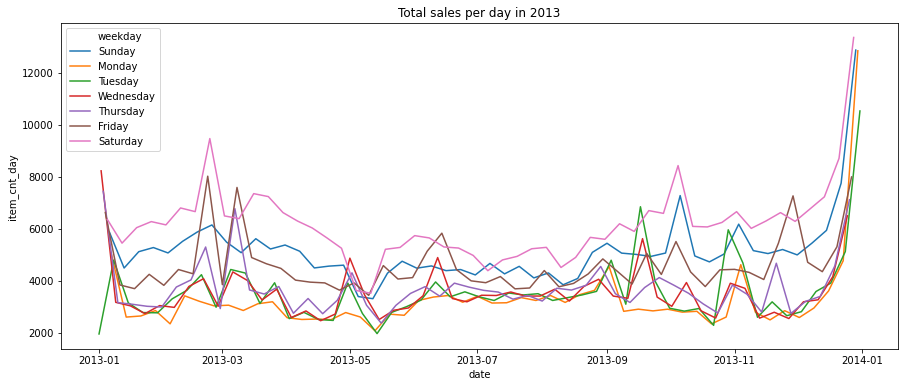

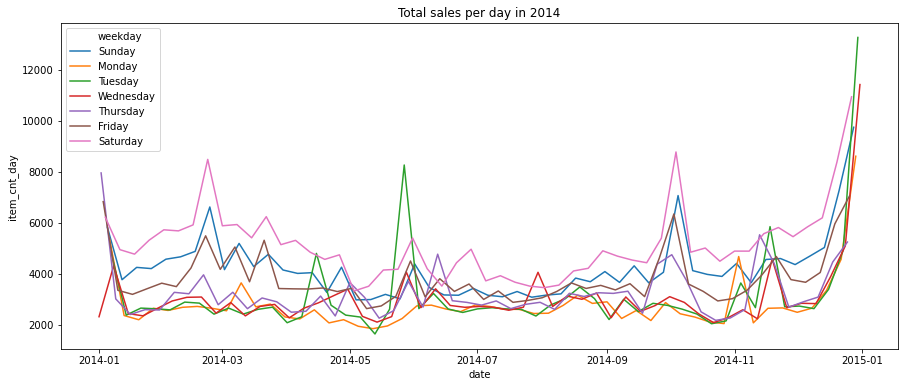

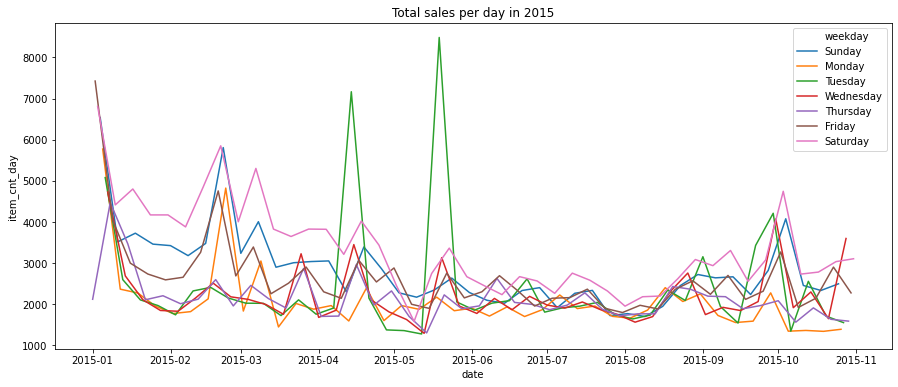

In [19]:
daily['weekday'] = daily.index.strftime('%A')

plt.figure(figsize=(15,6))
sns.lineplot(x='date', y='item_cnt_day', hue='weekday', hue_order = daily.iloc[5:].weekday.unique(), 
             data=daily.reset_index().iloc[0*365:1*365,:])
plt.title('Total sales per day in 2013')
plt.figure(figsize=(15,6))
sns.lineplot(x='date', y='item_cnt_day', hue='weekday', hue_order = daily.iloc[5:].weekday.unique(), 
             data=daily.reset_index().iloc[1*365:2*365,:])
plt.title('Total sales per day in 2014')
plt.figure(figsize=(15,6))
sns.lineplot(x='date', y='item_cnt_day', hue='weekday', hue_order = daily.iloc[5:].weekday.unique(), 
             data=daily.reset_index().iloc[2*365:3*365,:])
plt.title('Total sales per day in 2015')

As can be seen from the figures above, in overall, total sales on Saturday have higher values compared to the other weekdays. It can be understood that peak sales usually occurs on weekend. But that's not always the case. In several time points, total sales peak appeared on Tuesday, meaning that there might be some specific transactions on that time. 

### Weekly and monthly pattern

To gain insight about the sales pattern over the year, we will inspect the total number of sales in weekly and monthly frequency. This means that we must perform summation over the daily total sales in every week and every month.

In [20]:
df=df.set_index('date')
cols = ['date_block_num','shop_id','item_id','item_price']

Text(0.5, 1.0, 'Total sales per month from January 2013 - October 2015')

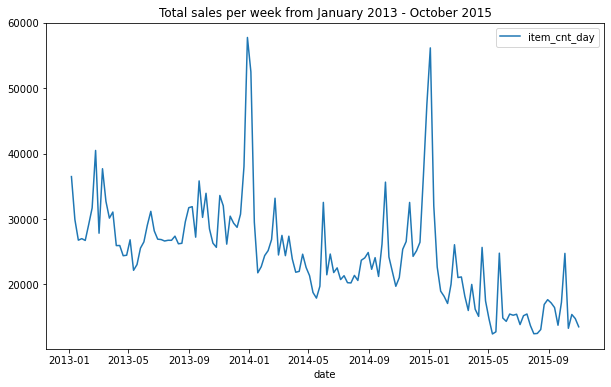

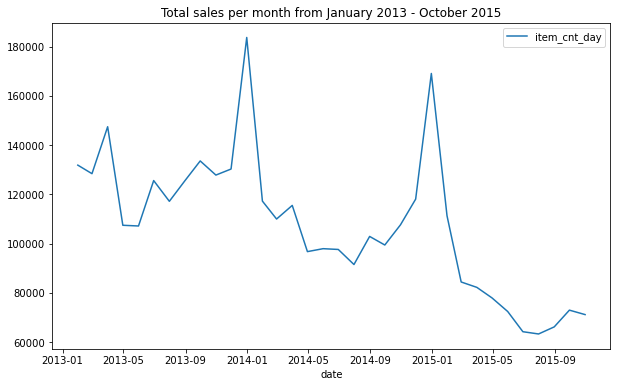

In [21]:
#weekly sales
weekly = df.resample('w').sum().drop(columns=cols)
plt.figure(figsize=(10,6))
sns.lineplot(data=weekly)
plt.title('Total sales per week from January 2013 - October 2015')

#monthly sales
monthly = df.resample('M').sum().drop(columns=cols)
plt.figure(figsize=(10,6))
sns.lineplot(data=monthly)
plt.title('Total sales per month from January 2013 - October 2015')

Several remarks can be seen here:
- Total sales tend to decrease over year (decreasing trend)
- Total sales reach its minimum value in around April - July 
- Total sales always reach its maximum value at the end of December (transition to New Year's Eve) 

Based on the discovered pattern and for further analysis, we will try to decompose our time series into trend and seasonal components. We will assume additive model for the decomposed components.

Text(0.5, 4.8, 'Monthly sales additive decomposition')

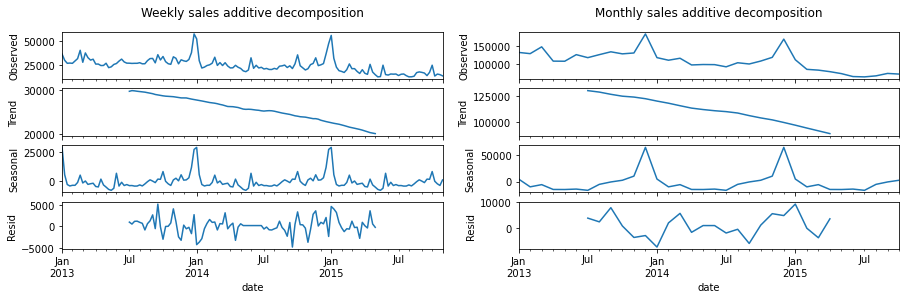

In [23]:
from statsmodels.tsa.seasonal import seasonal_decompose
fig, ax = plt.subplots(4,2,figsize=(15,4))

#weekly sales
decomp1 = seasonal_decompose(weekly,model='additive')
decomp1.observed.plot(ax=ax[0,0],ylabel='Observed',legend=None)
decomp1.trend.plot(ax=ax[1,0],ylabel='Trend',legend=None,sharex=ax[0,0])
decomp1.seasonal.plot(ax=ax[2,0],ylabel='Seasonal',legend=None,sharex=ax[0,0])
decomp1.resid.plot(ax=ax[3,0],ylabel='Resid',legend=None,sharex=ax[0,0])
ax[3,0].set_title('Weekly sales additive decomposition',x=0.5,y=4.8)

#monthly sales
decomp2 = seasonal_decompose(monthly,model='additive')
decomp2.observed.plot(ax=ax[0,1],ylabel='Observed',legend=None)
decomp2.trend.plot(ax=ax[1,1],ylabel='Trend',legend=None,sharex=ax[0,0])
decomp2.seasonal.plot(ax=ax[2,1],ylabel='Seasonal',legend=None,sharex=ax[0,0])
decomp2.resid.plot(ax=ax[3,1],ylabel='Resid',legend=None,sharex=ax[0,0])
ax[3,1].set_title('Monthly sales additive decomposition',x=0.5,y=4.8)

From the decomposed components result, we can see clear decreasing trend over year and yearly seasonality with peak at the end of the year.

### Checking for stationarity

Many statistical model for time series analysis require stationarity of the time series. Stationarity means that the properties of the time series do not change in time. Practically, stationary time series should have constant mean and variance value over time. To check wether a time series is stationary or not, we can perform statistical test. Common statistical test for stationarity are Augmented Dickey-Fuller (ADF) test and Kwiatkowski–Phillips–Schmidt–Shin (KPSS) test.

In [24]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
ts = Series(daily.dropna().item_cnt_day)
result1 = adfuller(ts)
print('-----ADF test-----')
print('ADF Statistic: %f' % result1[0])
print('p-value: %f' % result1[1])
print('Critical Values:')
for key, value in result1[4].items():
	print('\t%s: %.3f' % (key, value))
print('\n')
    
print('-----KPSS test-----')
result2 = kpss(ts,lags='auto')
print('KPSS Statistic: %f' % result2[0])
print('p-value: %f' % result2[1])
print('Critical Values:')
for key, value in result2[3].items():
	print('\t%s: %.3f' % (key, value))

-----ADF test-----
ADF Statistic: -4.041558
p-value: 0.001208
Critical Values:
	1%: -3.437
	5%: -2.864
	10%: -2.568


-----KPSS test-----
KPSS Statistic: 2.474714
p-value: 0.010000
Critical Values:
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739


C:\Users\ASUS\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1708: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)


How to interpret the test results to determine stationarity?
- ADF test: the series is stationary if p-value < significance level and ADF statistic < critical values
- KPSS test: the series is stationary if p-value > significance level and KPSS statistic < critical values

From the results above, if we choose 5% (0.05) significance level, then the ADF test results show that our time series is stationary. On the other hand, KPSS test results reveal that our time series is not stationary. It might be that our daily sales pattern indeed has a trend, but the trend is not too significant. To overcome this problem, we can try to detrend the times series by differencing it by one lag.

Text(0, 0.5, 'differenced total sales')

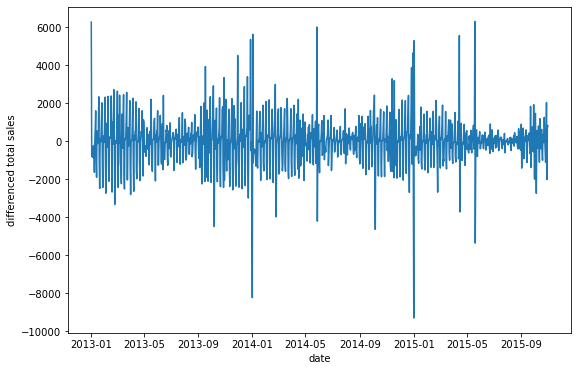

In [25]:
plt.figure(figsize=(9,6))
sns.lineplot(data=daily.item_cnt_day.diff(1))
plt.xlabel('date')
plt.ylabel('differenced total sales')

After differencing by one lag, we can see that there is no more visible trend pattern and the mean value of the series is relatively constant over time. Let's check the stationarity test result for this differenced time series.

In [26]:
ts = Series(daily.item_cnt_day.diff(1).dropna())
result1 = adfuller(ts)
print('-----ADF test-----')
print('ADF Statistic: %f' % result1[0])
print('p-value: %f' % result1[1])
print('Critical Values:')
for key, value in result1[4].items():
	print('\t%s: %.3f' % (key, value))
print('\n')
    
print('-----KPSS test-----')
result2 = kpss(ts,lags='auto')
print('KPSS Statistic: %f' % result2[0])
print('p-value: %f' % result2[1])
print('Critical Values:')
for key, value in result2[3].items():
	print('\t%s: %.3f' % (key, value))

-----ADF test-----
ADF Statistic: -9.064193
p-value: 0.000000
Critical Values:
	1%: -3.437
	5%: -2.864
	10%: -2.568


-----KPSS test-----
KPSS Statistic: 0.081186
p-value: 0.100000
Critical Values:
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739


C:\Users\ASUS\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1710: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)


It works! After differencing, the above test results (both ADF and KPSS test) indicate that our time series is stationary. This information will be valuable for selecting parameter model later.

## Forecasting with SARIMA

Now, let's proceed to the forecasting step. We will use a popular and widely used statistical method for time series forecasting: ARIMA model. Moreover, because our time series has seasonal pattern in weekly frequency, we will use seasonal ARIMA (SARIMA) model. In order to find the parameter order required, let's look to autocorrelation (ACF) and partial autocorrelation (PACF) plot of the series.

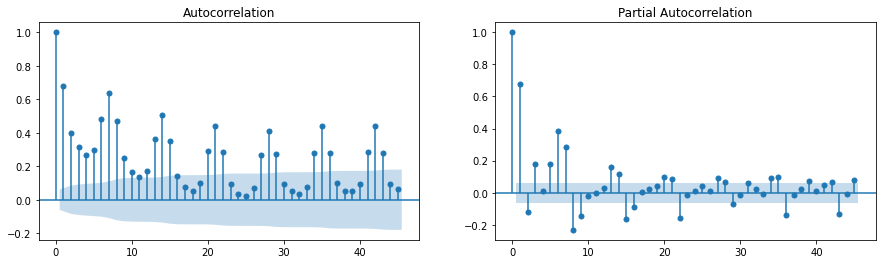

In [28]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
ts = Series(daily.dropna().item_cnt_day)
fig, ax = plt.subplots(1,2,figsize=(15,4))
plot_acf(ts,ax=ax[0],lags=45)
plot_pacf(ts,ax=ax[1],lags=45)
plt.show()

We can see that in ACF plot, there is a periodic pattern every 7 lag with decaying value. In PACF plot, we can see significant lag at 3 before it decays. There is also periodic pattern in PACF plot but the pattern is weak. From the stationarity test section, we also know that our series must be differenced by 1 lag to make it stationary. In summary, let's use SARIMA model with order parameter (1,1,3)(1,0,1)7. Mean absolute error (MAE) will be used for the forecasting metrics.

Note: because forecasting will be done using expanding window method, this may take a while.

In [101]:
import warnings
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error as MAE
warnings.filterwarnings("ignore")

#split training and test set
ts = Series(daily.dropna().item_cnt_day)
train_size = int(len(ts) * 0.8)
train, test = ts[0:train_size], ts[train_size:]
history = [x for x in train]

#make predictions with expanding window method
preds = list()
for t in range(len(test)):
    model = SARIMAX(history, order=(1,1,3),seasonal_order=(1,0,1,7),enforce_stationarity=False, 
                    enforce_invertibility=False).fit()
    yhat = model.forecast()[0]
    preds.append(yhat)
    history.append(test[t])
    
# calculate out of sample error
score = MAE(test, preds)
print('Mean absolute error(MAE) score: %f' %(score))

Mean absolute error(MAE) score: 393.518906


With this SARIMA model, we get MAE score of 393.52. Now, to further see the forecasting performance of this model, we will look into the residual correlation plot and forecasting plot.

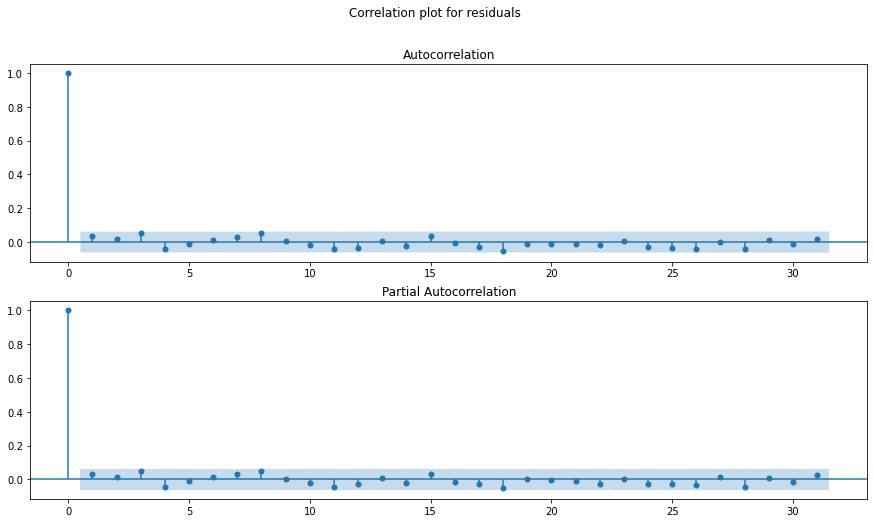

In [100]:
res = sarima.resid
fig,ax = plt.subplots(2,1,figsize=(15,8))
fig = plot_acf(res, ax=ax[0])
fig = plot_pacf(res, ax=ax[1])
plt.suptitle('Correlation plot for residuals')
plt.show()

Text(0.5, 1.0, 'Forecasting with SARIMA(1,1,3)(1,0,1)7 model')

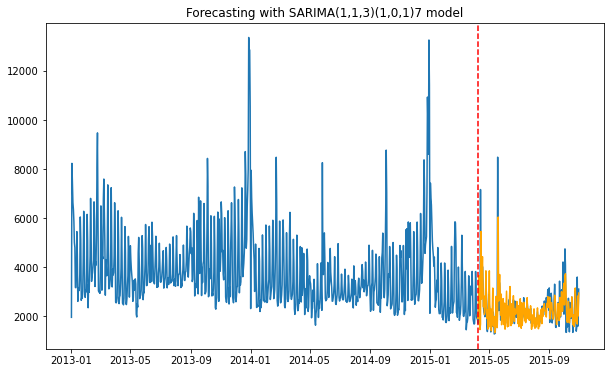

In [89]:
predicted = Series(preds,index=test.index)
plt.figure(figsize=(10,6))
sns.lineplot(data=ts)
sns.lineplot(data=predicted,color='orange')
plt.axvline(x=ts.index[train_size],color='red',linestyle='dashed')
plt.title('Forecasting with SARIMA(1,1,3)(1,0,1)7 model')

Text(0.5, 1.0, 'Forecasting result on the test period')

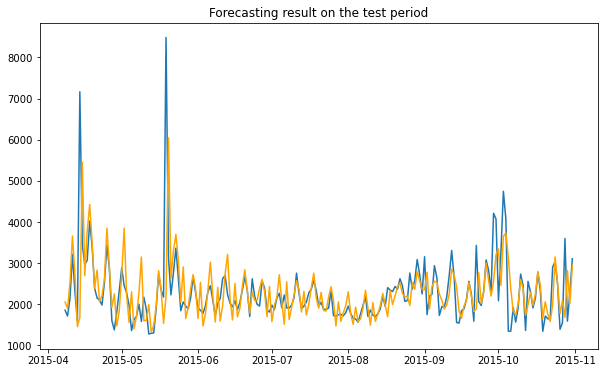

In [98]:
plt.figure(figsize=(10,6))
sns.lineplot(data=ts[train_size:])
sns.lineplot(data=predicted,color='orange')
plt.title('Forecasting result on the test period')

From the residuals correlation plot, we can see that the correlation value do not reach the significance level. This means that our model have a good performance in forecasting sales. Looking into the forecasting plot, SARIMA model can capture nearly all of the seasonal pattern with quietly small error when predicting exact values of total sales.

## Conclusion

Several conclusions can be drawn from these studies:
- Every shop in 1C-Company has its own unique pattern with different trend and different number of records.
- Total daily sales on Saturday have higher values compared to the other weekdays, except for several time points in which sales peak appeared on Tuesday.
- In weekly and monthly frequency, total sales has decreasing trend and yearly seasonal pattern with peak at the end of the year.
- The non-stationarity of the daily sales time series can be handled by differencing it by one lag.
- Forecasting can be done using SARIMA model with order parameter (1,1,3)(1,0,1,7) and the forecasting result has MAE score of 393.48.